In [1]:
# Load necessary libraries

import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import  shap
import matplotlib.colors as mcolors

In [6]:
# set the data path
data_path = Path.cwd().parent/'datas'

# Load training data
df = pd.read_csv(data_path / 'training_data.csv')

# Select features
X, y = df.iloc[:, list(range(1, 34))], df['homo_infected']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, stratify=y)

# Create DMatrix
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

# load model
model_path = Path.cwd().parent/'models'

XGB_cli_model = xgb.Booster()
XGB_cli_model.load_model(model_path / "XGB_cli.json")

### 计算最佳F1 score的截断值

In [3]:
# Define thresholds to generate in increments of 0.05
thresholds = np.arange(0.1, 1.0, 0.05)

# Initialize the highest F1 score and corresponding threshold
max_f1, best_threshold = 0, 0

# Calculate precision and recall
y_prob = XGB_cli_model.predict(dtest)

for threshold in thresholds:
    
    y_pred = (y_prob > threshold).astype(int)

    f1 = f1_score(y_test, y_pred)

    if f1 > max_f1:
        max_f1 = f1
        f1_threshold = threshold

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
best_index = np.argmin(distances)
auc_thresholds = thresholds[best_index]

# Print the best threshold for the F1 score
print(f"Best F1 threshold: {f1_threshold:.2f}")

# Print the best threshold found via ROC curve analysis
print(f"Best AUC threshold: {auc_thresholds:.2f}")

Best F1 threshold: 0.20
Best AUC threshold: 0.52


In [4]:
thresholds = [f1_threshold, auc_thresholds]

for threshold in thresholds:
    # 计算预测结果
    y_pred = (y_prob > threshold).astype(int)
    
    # 计算准确度
    ac = accuracy_score(y_test, y_pred)
    # 计算logloss
    ll = log_loss(y_test, y_prob)
    # 精确度
    precision = precision_score(y_test, y_pred)
    # 计算recall
    recall = recall_score(y_test, y_pred)
    # 计算f1
    f1 = f1_score(y_test, y_pred)
    # 计算AUC
    auc = roc_auc_score(y_test, y_prob)

    print(f"Threshold: {threshold}\n"
          f"Accuracy: {ac:.4f}\n"
          f"Log Loss: {ll:.4f}\n"
          f"Precision: {precision:.4f}\n"
          f"Recall: {recall:.4f}\n"
          f"F1 Score: {f1:.4f}\n"
          f"AUC: {auc:.4f}\n")

Threshold: 0.20000000000000004
Accuracy: 0.9477
Log Loss: 0.1547
Precision: 0.9639
Recall: 0.9705
F1 Score: 0.9672
AUC: 0.9827

Threshold: 0.5217955708503723
Accuracy: 0.9383
Log Loss: 0.1547
Precision: 0.9855
Recall: 0.9362
F1 Score: 0.9602
AUC: 0.9827


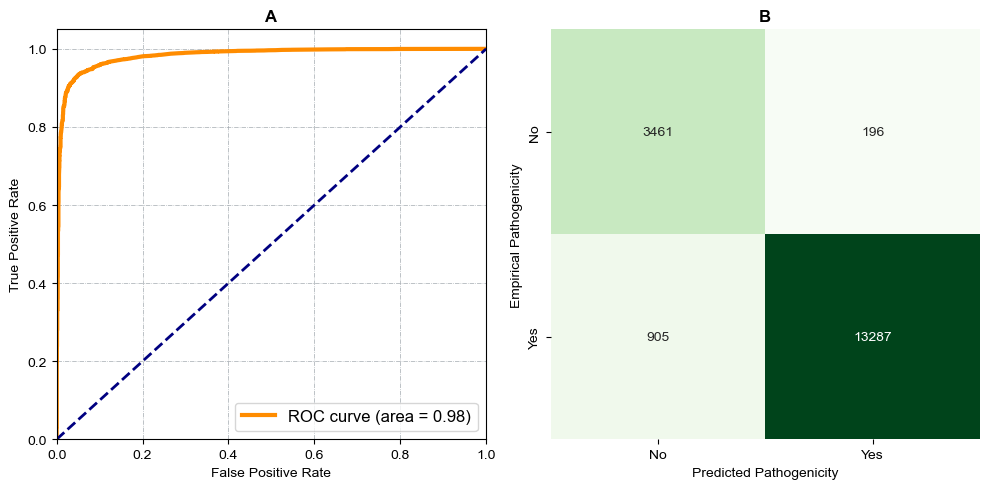

In [10]:
plot_path = Path.cwd().parent/'plots'
plot_path.mkdir(parents=True, exist_ok=True)

# Initialize figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Set global font
plt.rcParams['font.sans-serif'] = 'Arial'

# Plot ROC curve
axs[0].plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (area = {auc:.2f})')
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate', fontsize=10)
axs[0].set_ylabel('True Positive Rate', fontsize=10)
axs[0].set_title('A', fontsize=12, fontweight='bold')
axs[0].legend(loc="lower right", fontsize=12, facecolor='white')

# Enhance plot aesthetics
axs[0].set_facecolor('white')
axs[0].grid(which='major', linestyle='-.', linewidth='0.5', color='#a2a9af')
for spine in axs[0].spines.values():
    spine.set_edgecolor('black')
axs[0].patch.set_edgecolor('black')

# Predict and compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False, ax=axs[1])
axs[1].set_xlabel("Predicted Pathogenicity", fontsize=10)
axs[1].set_ylabel("Empirical Pathogenicity", fontsize=10)
axs[1].set_title("B", fontsize=12, fontweight='bold')
axs[1].set_xticklabels(['No', 'Yes'])
axs[1].set_yticklabels(['No', 'Yes'])
axs[1].tick_params(axis='both', labelsize=10)

plt.tight_layout()

# plt.savefig(plot_path / "model_Performance.tiff", dpi=600, bbox_inches='tight')

plt.show()

In [7]:
# Get result
importance_weight = XGB_cli_model.get_score(importance_type="weight")
importance_gain = XGB_cli_model.get_score(importance_type="gain")
importance_cover = XGB_cli_model.get_score(importance_type="cover")

# Converting dict to dataFrame
df_weight = pd.DataFrame.from_dict(importance_weight, orient='index', columns=['weight'])
df_gain = pd.DataFrame.from_dict(importance_gain, orient='index', columns=['gain'])
df_cover = pd.DataFrame.from_dict(importance_cover, orient='index', columns=['cover'])

# merge
df_importance = pd.concat([df_weight, df_gain, df_cover], axis=1)
df_importance = df_importance.sort_values('gain',)

df_importance

,weight,gain,cover
host_cell_death,50.0,0.421483,605.076965
size,14828.0,2.537190,389.617310
host_transcription,97.0,12.840670,901.123962
viral_counter_signaling,230.0,12.899837,281.125824
host_ubiquitin,48.0,22.980246,1087.506958
viral_invasion,209.0,26.369390,899.913818
host_xenophagy,138.0,28.498276,682.198303
viral_adhesion,441.0,85.776443,491.303772


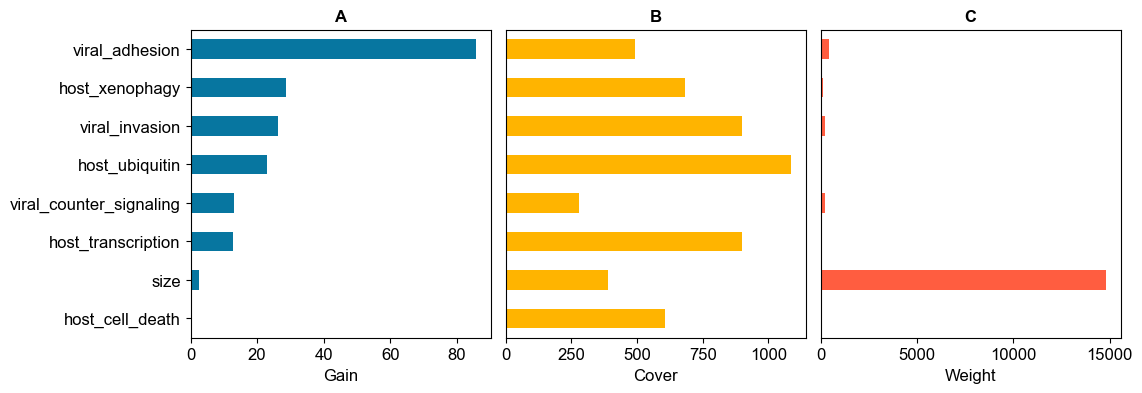

In [11]:
# Set global font style
plt.rc('font', family='Arial')

# Create a 1x3 grid of subplots with shared y-axis
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharey=True)

# Plot 'gain' column as a horizontal bar chart in the first subplot
df_importance['gain'].plot.barh(ax=axes[0], color='#0776a0', fontsize=12)
axes[0].set_xlabel('Gain', fontsize=12)
axes[0].set_title('A', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='both', labelsize=12)

# Plot 'cover' column as a horizontal bar chart in the second subplot
df_importance['cover'].plot.barh(ax=axes[1], color='#ffb400', fontsize=12)
axes[1].set_xlabel('Cover', fontsize=12)
axes[1].set_title('B', fontsize=12, fontweight='bold')
axes[1].yaxis.set_visible(False)  # Hide y-axis labels for the second subplot
axes[1].tick_params(axis='both', labelsize=12)

# Plot 'weight' column as a horizontal bar chart in the third subplot
df_importance['weight'].plot.barh(ax=axes[2], color='#ff5d40', fontsize=12)
axes[2].set_xlabel('Weight', fontsize=12)
axes[2].set_title('C', fontsize=12, fontweight='bold')
axes[2].yaxis.set_visible(False)  # Hide y-axis labels for the third subplot
axes[2].tick_params(axis='both', labelsize=12)

# Adjust the width between subplots
plt.subplots_adjust(wspace=0.05)

# Save the figure to a file
# plt.savefig(plot_path / "function_xg.tiff", dpi=600, bbox_inches='tight')

# Show the plot
plt.show()


### 使用shap解释模型中不同特征的性能

In [7]:
# Initialize SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(XGB_cli_model)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

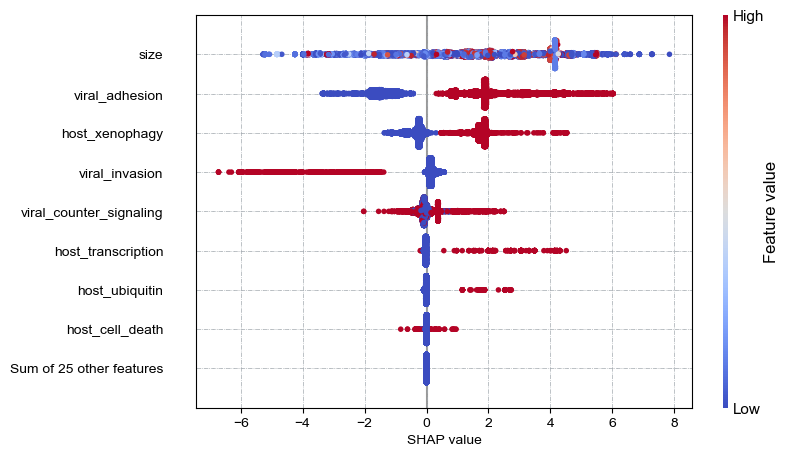

In [16]:
# Plot SHAP values using a beeswarm plot
shap.plots.beeswarm(shap_values, max_display=9, show=False, color="coolwarm", axis_color="black")

# Access the current Axes object for customization
ax = plt.gca()

# Set background color to white
ax.set_facecolor('white')

# Set major grid lines' style and color
ax.grid(which='major', linestyle='-.', linewidth='0.5', color='#a2a9af')

# Customize the appearance of axis spines
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('black')

# Customize font size and style for the x-axis label
plt.xlabel("SHAP value", fontsize=10, fontname='Arial')

# Customize tick labels' font size and style
plt.xticks(fontsize=10, fontname='Arial')
plt.yticks(fontsize=10, fontname='Arial')

# Save the figure
# plt.savefig(plot_path / "function_shap.tiff", dpi=600, bbox_inches='tight')

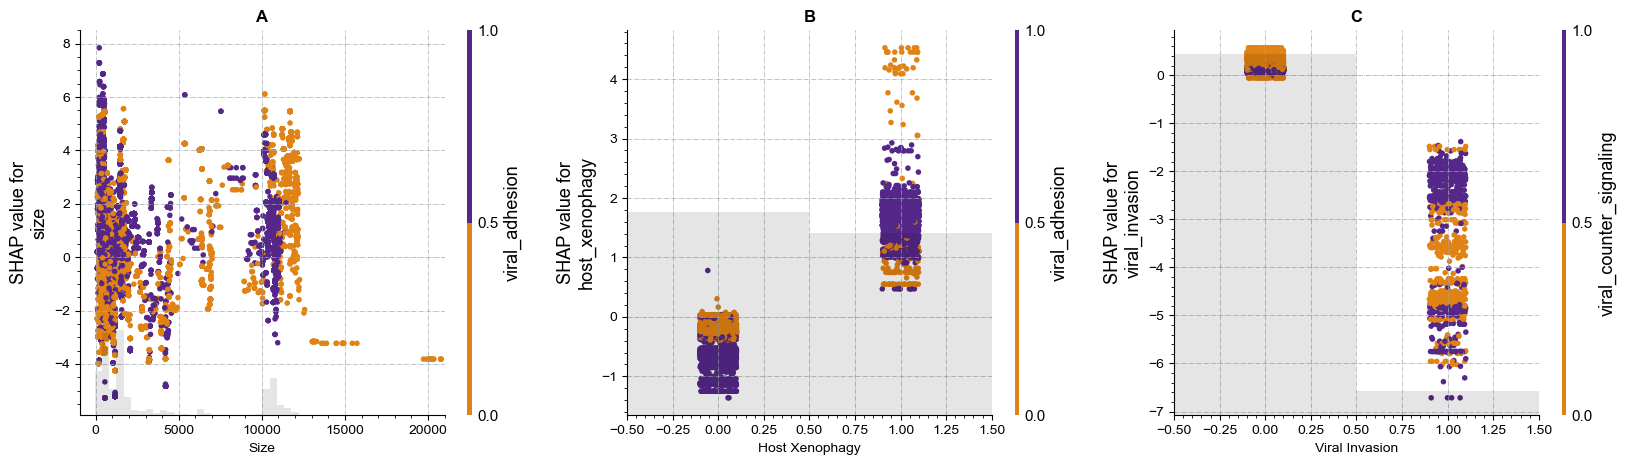

In [22]:
# set color
color_2 = mcolors.LinearSegmentedColormap.from_list(
    "mycmap", ['#e08214', '#542788']
)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))  

shap.plots.scatter(shap_values[:, "size"], color=shap_values, axis_color='black',title="A", cmap=color_2, xmax=21000, show=False, ax=axs[0])
axs[0].set_facecolor('white')
axs[0].minorticks_on()
axs[0].grid(which='major', linestyle='-.', linewidth='0.5', color='#a2a9af')
axs[0].set_xlabel("Size", fontsize=10, fontname='Arial')  
axs[0].set_title('A', fontsize=12, fontweight='bold', fontname='Arial')
axs[0].tick_params(axis='both', labelsize=10)

shap.plots.scatter(shap_values[:, "host_xenophagy"], color=shap_values, axis_color='black', cmap=color_2, show=False, ax=axs[1])
axs[1].set_facecolor('white')
axs[1].minorticks_on()
axs[1].grid(which='major', linestyle='-.', linewidth='0.5', color='#a2a9af')
axs[1].set_xlabel("Host Xenophagy", fontsize=10, fontname='Arial')  
axs[1].set_title('B', fontsize=12, fontweight='bold', fontname='Arial')
axs[1].tick_params(axis='both', labelsize=10)

shap.plots.scatter(shap_values[:, "viral_invasion"], color=shap_values, axis_color='black', cmap=color_2, show=False, ax=axs[2])
axs[2].set_facecolor('white')
axs[2].minorticks_on()
axs[2].grid(which='major', linestyle='-.', linewidth='0.5', color='#a2a9af')
axs[2].set_xlabel("Viral Invasion", fontsize=10, fontname='Arial')  
axs[2].set_title('C', fontsize=12, fontweight='bold', fontname='Arial')
axs[2].tick_params(axis='both', labelsize=10)

# Save the figure
# plt.savefig(plot_path / "interaction_shap.tiff", dpi=600, bbox_inches='tight')

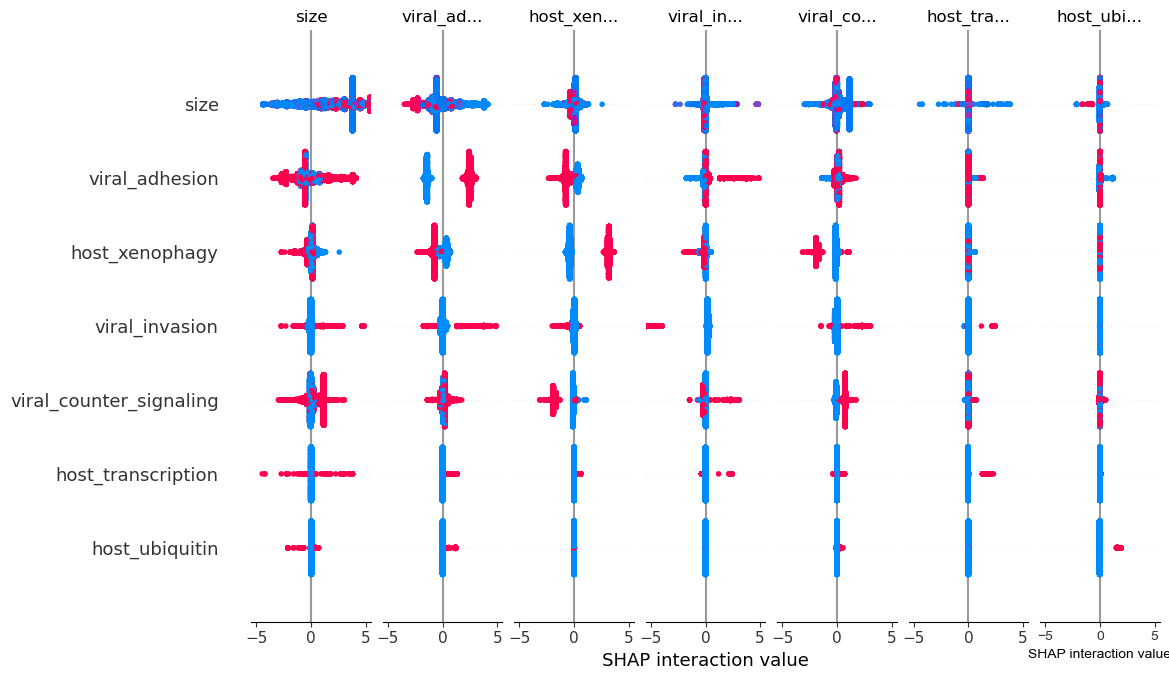

In [9]:
# all_interaction_values
shap_interaction_values = explainer.shap_interaction_values(X_test)

shap.summary_plot(shap_interaction_values, X_test,show=False)

ax = plt.gca()

fig = plt.gcf()

plt.xlabel("SHAP interaction value", fontsize=10, fontname='Arial')  

plt.xticks(fontsize=10, fontname='Arial')
plt.yticks(fontsize=10, fontname='Arial')
plot_path = Path.cwd().parent/'plots'

plt.savefig(plot_path / "all_interaction_shap.tiff", dpi=600, bbox_inches='tight')

In [3]:
# set the data path
data_path = Path.cwd().parent/'datas'

# Load training data
df = pd.read_csv(data_path / 'training_data.csv')

# Select features
X, y = df.iloc[:, list(range(1, 34))], df['homo_infected']

# check the positive class ratio
positive_class_ratio = (df['homo_infected'] == 1).sum() / len(df)

# Calculate scale_pos_weight
scale_pos_weight = ((1 - positive_class_ratio) / positive_class_ratio)

# Create total data DMatrix
dtotal = xgb.DMatrix(X, y, enable_categorical=True)

# load model
model_path = Path.cwd().parent/'models'

# set paramters
params = {"objective": "binary:logistic", 
          "tree_method": "exact",
          "scale_pos_weight" : scale_pos_weight,
          "eta":0.15,
          }

# Number of boosting rounds
n_rounds = 10000
cv_results = xgb.cv(
    params, dtotal,
    num_boost_round=n_rounds,
    nfold=5,
    early_stopping_rounds=20,
    metrics="auc",
    as_pandas=True,
    seed=42
)

# Determine the best number of iterations
best_iteration = cv_results.shape[0]

# Train the final model
final_model = xgb.train(params, dtotal, num_boost_round=best_iteration)

# Correct approach to create a directory and save the model
model_dir = data_path.parent / "models"
model_dir.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists

model_file_path = model_dir / "Total_XGB_cli.json"  # Full path for the model file

final_model.save_model(str(model_file_path))  # Save the model
